# Preliminary EDA for Landsat 8 Surface Temp Data
Chase Dawson

In [99]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

%matplotlib inline

In [100]:
def read_files(basename, spatial_units):
    data = {}
    for spatial_unit in spatial_units:
        path = 'landsat8_{basename}_{spatial_unit}.csv'.format(basename = basename, spatial_unit = spatial_unit)
        df = pd.read_csv(path, index_col = 0)
        data[spatial_unit] = df
    return data

In [102]:
def read_spatial_data(basename, clip_coast=False):
    """
    Reads in spatial data that is in the format 'basename_spatialUnit.shp'.
    
    Parameters
    ----------
    basename : str, required
        Base name of shape files. For example, if the files you want to read are of the format
        'cville_counties.shp', 'cville_blocks.shp', etc. then the basename is 'cville'.
        
    clip_coast : bool, optional (default is False)
        If True, shp data will be compared to coast line data and oceans will be clipped out.
    
    Output
    ------
    dictionary containing geopandas dataframes for each spatial unit
    
    """
    print('Reading spatial data for {basename}...'.format(basename = basename))
    # read in coast line data 
    if clip_coast:
        ocean = gpd.read_file('water/ne_10m_ocean.shp')
    
    # store current working directory
    og_wd = os.getcwd()
    
    # change working directory to where spatial data is located
    os.chdir("../spatial_units/data")
    
    # create empty dictionary
    data = {}
    
    if clip_coast:
        spatial_units = ['blocks', 'blkgps', 'tracts']

        # read in counties and clip first
        print("Reading counties...")
        counties = gpd.read_file(basename + '_counties.shp')
        ocean = ocean.to_crs(counties.crs)
        counties = gpd.overlay(counties, ocean, how='difference')
        data['counties'] = counties
        print("Done.")
    
        # read in rest of shapefiles, clip respective to counties, store as keys in dict
        for spatial_unit in spatial_units:
            print("Reading {spatial_unit}...".format(spatial_unit = spatial_unit))
            # read in shp file
            shp = gpd.read_file(basename + '_{spatial_unit}.shp'.format(spatial_unit = spatial_unit))

            # convert coast line data to crs of shp 
            counties = counties.to_crs(shp.crs)

            # clip out ocean
            shp = gpd.overlay(shp, counties[['geometry']], how='intersection', keep_geom_type=True)

            # add dict with spatial unit as key
            data[spatial_unit] = shp
            print("Done.")
            
    else:
        spatial_units = ['counties', 'blocks', 'blkgps', 'tracts']
        for spatial_unit in spatial_units:
            print("Reading {spatial_unit}...".format(spatial_unit = spatial_unit))
            shp = gpd.read_file(basename + '_{spatial_unit}.shp'.format(spatial_unit = spatial_unit))
            data[spatial_unit] = shp
            print("Done.")

    # reset back to original working directory
    os.chdir(og_wd)
    
    return data

In [259]:
cville_data = read_files('cville', ['counties', 'tracts', 'blkgps'])
cville_shp = read_spatial_data('cville')

Reading spatial data for cville...
Reading counties...
Done.
Reading blocks...
Done.
Reading blkgps...
Done.
Reading tracts...
Done.


In [260]:
easternShore_data = read_files('easternShore', ['counties', 'tracts', 'blkgps'])
easternShore_shp = read_spatial_data('eastshore', clip_coast = True)

Reading spatial data for eastshore...
Reading counties...
Done.
Reading blocks...
Done.
Reading blkgps...
Done.
Reading tracts...
Done.


In [261]:
cols_wanted = {
    'counties': ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'geometry'],
    'tracts': ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'geometry'],
    'blkgps': ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD', 'geometry']
}

In [262]:
def merge_geoms(data, shp):
    for spatial_unit in data:
        shp[spatial_unit] = shp[spatial_unit][cols_wanted[spatial_unit]]
        data[spatial_unit]["GEOID"] = data[spatial_unit]["GEOID"].apply(lambda x: str(x))
        shp[spatial_unit]["GEOID"] = shp[spatial_unit]["GEOID"].apply(lambda x: str(x))
        data[spatial_unit] = data[spatial_unit].set_index("GEOID").join(shp[spatial_unit].set_index("GEOID"), on="GEOID", how="inner")
        data[spatial_unit] = gpd.GeoDataFrame(data[spatial_unit])
    return data

In [263]:
cville = merge_geoms(cville_data, cville_shp)
easternShore = merge_geoms(easternShore_data, easternShore_shp)

In [264]:
cville['counties'].columns

Index(['file', 'min', 'max', 'mean', 'count', 'median', 'nodata',
       'masked_count', 'spatial_unit', 'basename', 'full_path', 'prop_nodata',
       'entity_id', 'start_date', 'end_date', 'start_year', 'end_year',
       'cloud_cover', 'area', 'shp_percent', 'spatial_bounds',
       'spatial_coverage', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME',
       'geometry'],
      dtype='object')

In [141]:
cville_files = cville['counties'].file.value_counts().index.tolist()
cville_files

['LC08_L2SP_016034_20200906_20200918_02_T1',
 'LC08_L2SP_016034_20200704_20200913_02_T1',
 'LC08_L2SP_016034_20200922_20201005_02_T1',
 'LC08_L2SP_016033_20200922_20201005_02_T1',
 'LC08_L2SP_016034_20200720_20210330_02_T1',
 'LC08_L2SP_016033_20200906_20200918_02_T1',
 'LC08_L2SP_015034_20200713_20200912_02_T1']

In [241]:
import numpy as np

def plot_file(file, data, col="median", cmap="inferno"):
    spatial_units = ['counties', 'tracts', 'blkgps']
    f, axs = plt.subplots(3, figsize=(25, 25))
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    # set axes index
    axi = 0
    for spatial_unit in spatial_units:
        ax = axs[axi]
        to_plot = data[spatial_unit]
        to_plot = to_plot[to_plot.file == file]
        
        # set to None values that have prop_nodata less than threshold
        # to_plot.median = to_plot.apply(lambda x: x.median if x.prop_nodata < nodata_threshold else np.nan, axis=1)

        basename = to_plot.basename.iloc[0]
        date = to_plot.start_date.iloc[0]
        
        # set labels
        ax.set_title('{file} {basename} {spatial_unit} {date}'.format(file = file, basename = basename, spatial_unit = spatial_unit, date = date))
        ax.set(xlabel='Longitude', ylabel="Latitude")
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        to_plot.plot(col, cmap = cmap, legend=True, ax=ax, cax=cax, missing_kwds={'color': 'lightgray'})
        # cmap.set_label("Degrees Fahrenheight")
        axi += 1

## Surface Temperature Data
This section examines the median surface temperature. The Landsat 8 dataset is comprised of scenes. A scene is basically a picture of some part of the Earth which contains data in the form of a raster. From those scenes, we can compute zonal statistics given geometries, such as county, tract, or block group boundaries. There has been some difficulty computing zonal stats at the block level, so we exclude those for now. 

The data for a given scene is captured at a specific time and day, thus there isn't necessarily one data source we can use for the surface temperature. In this exploration part, we iterate over all scenes and all spatial units and produce chloropleth plots of the median surface temperature in degrees Fahrenheight. This means there are a LOT of plots! 

A given plot is titled with the format "filename basename spatial_unit date", where filename is the name of the file, basename is the name of the region (either "cville" for Charlottesville or "easternShore" for the Eastern Shore), spatial_unit is the spatial unit at which the zonal stats were computed (counties, tracts, or block groups), and date is the date when the data was acquired (or when the satellite took a photo of that region).

### Missingness

If a geographic reigon (region is this sense means one geometry, so one county, tract, or block group) is fully missing data, it will be grayed out. I discuss/explore missingness in further detail later on.

### Charlottesville Region Temperature Data

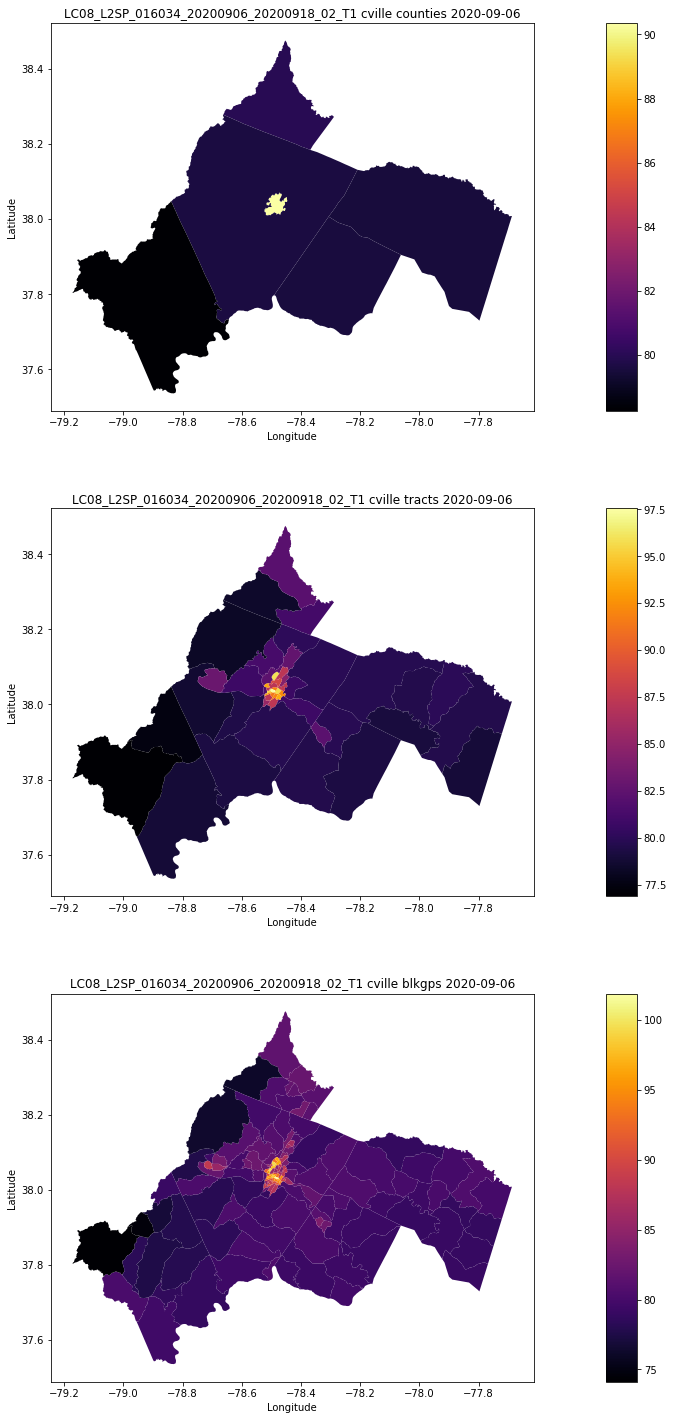

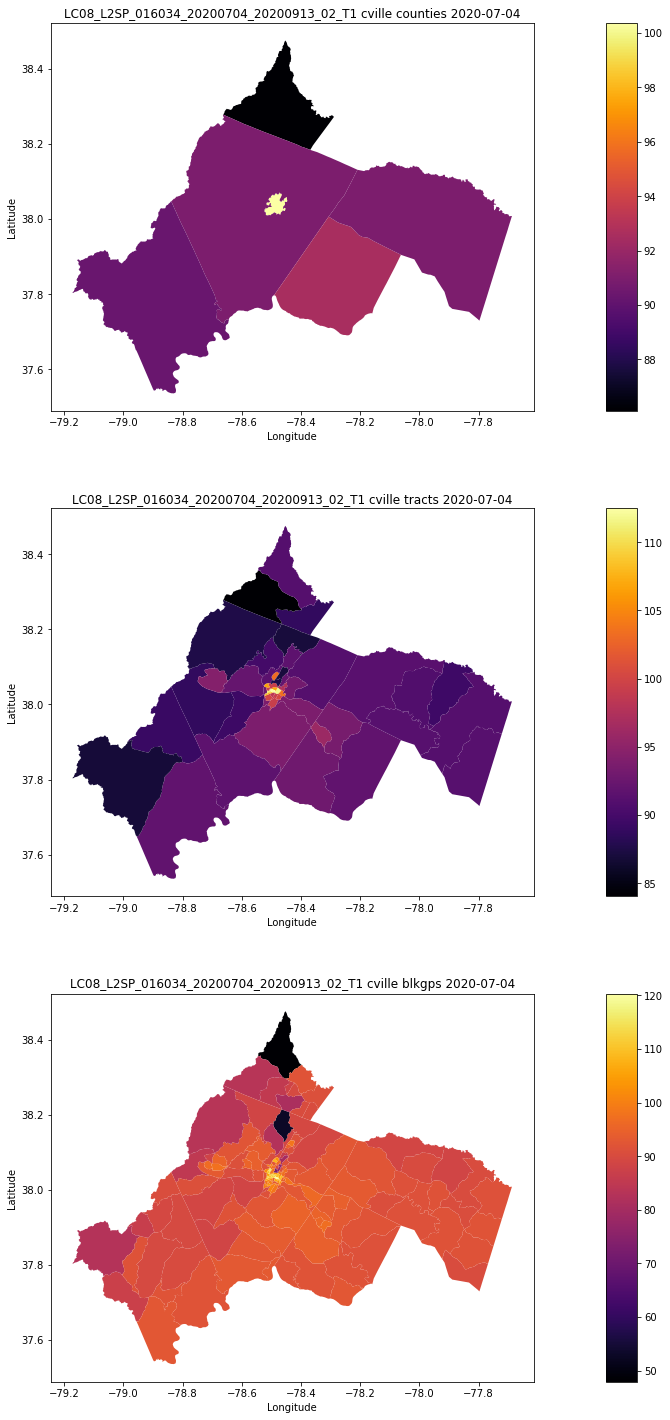

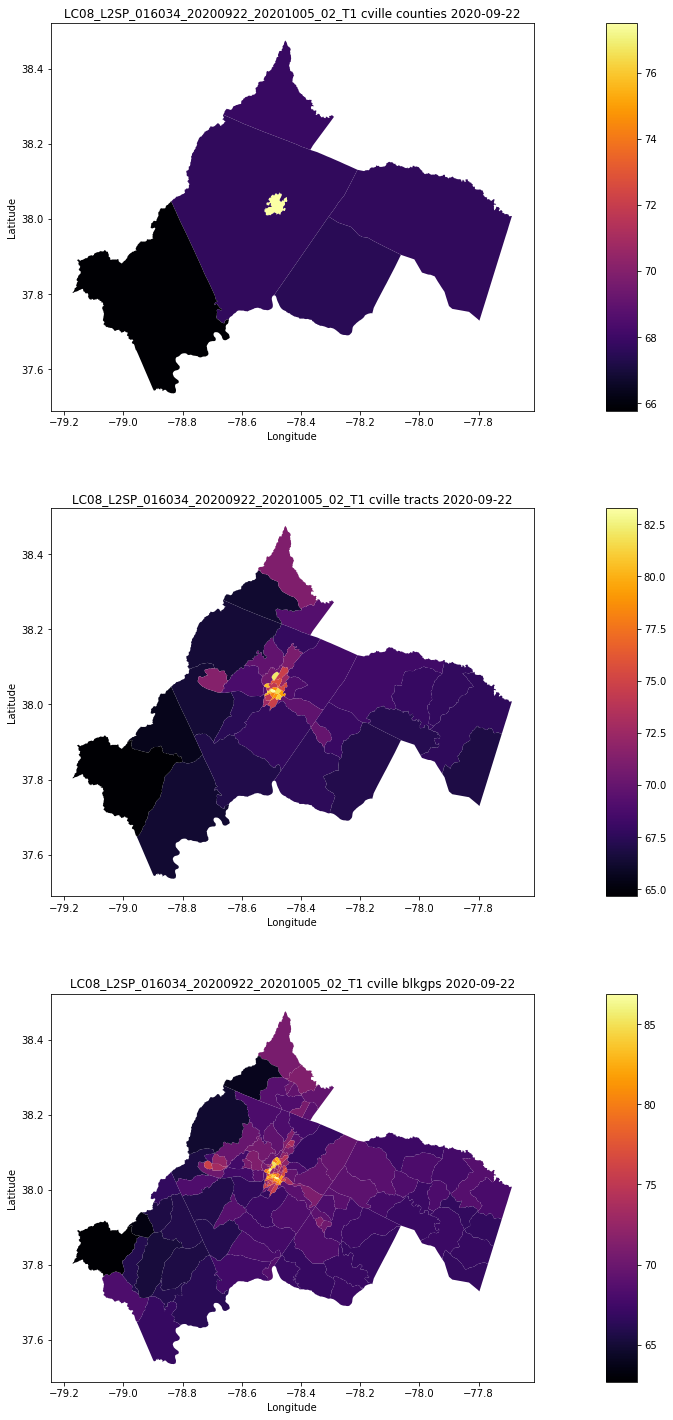

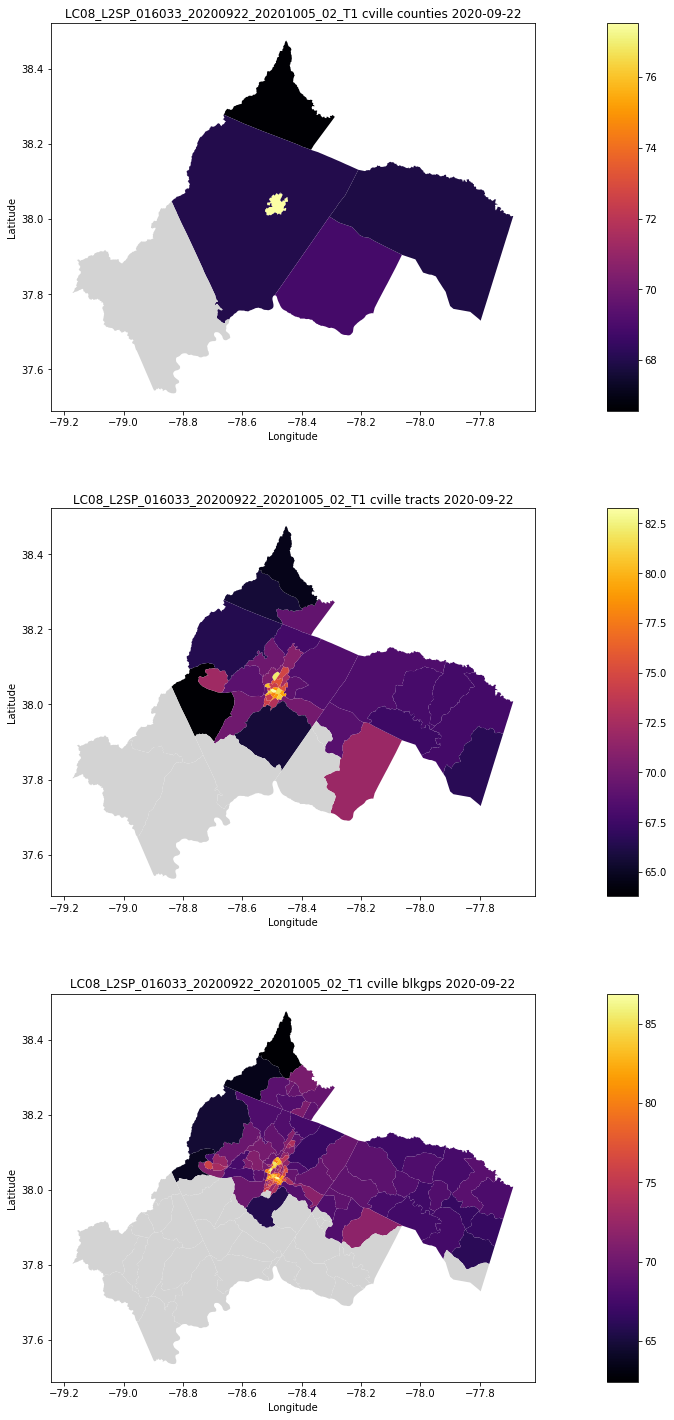

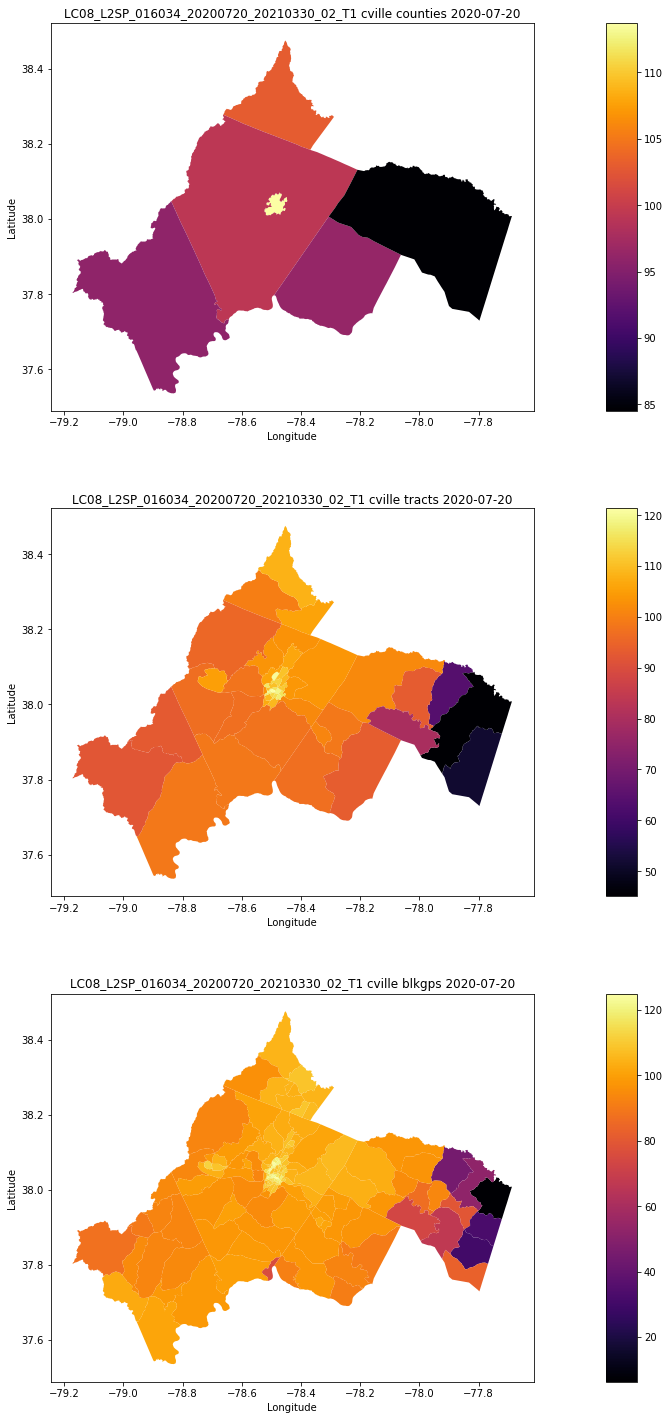

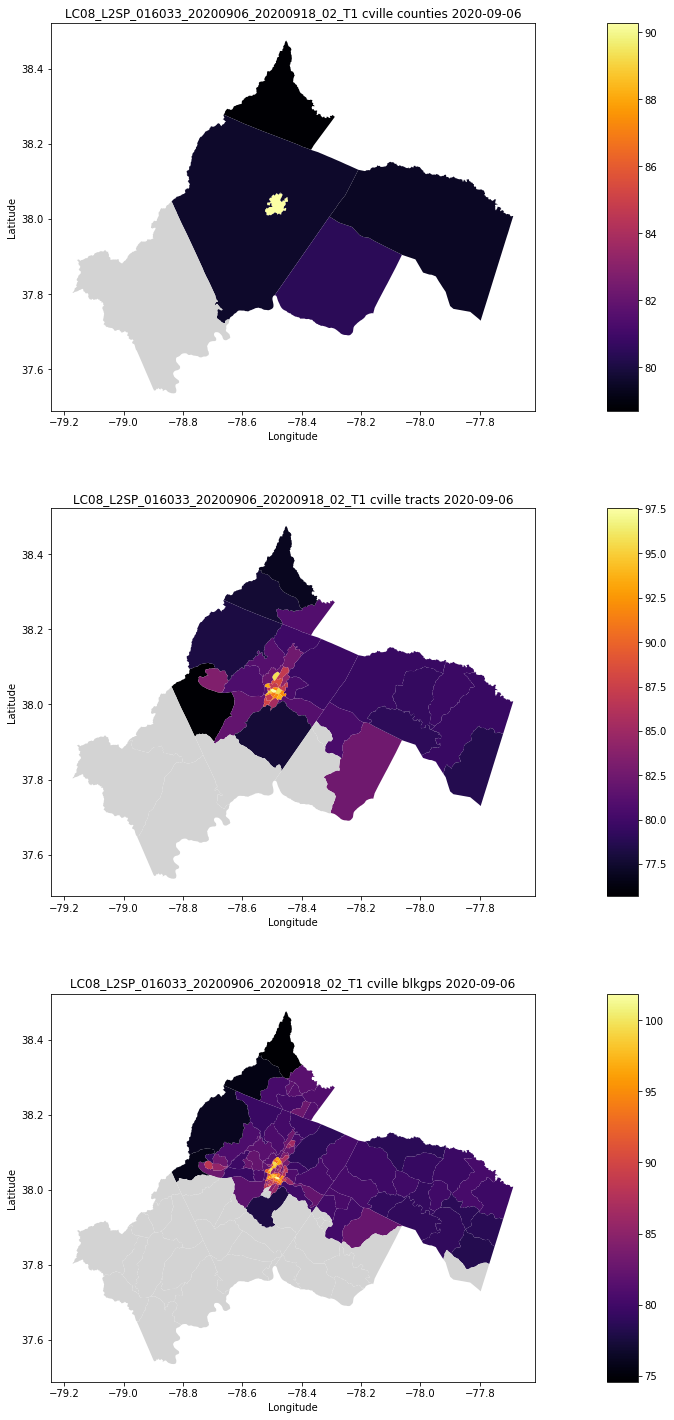

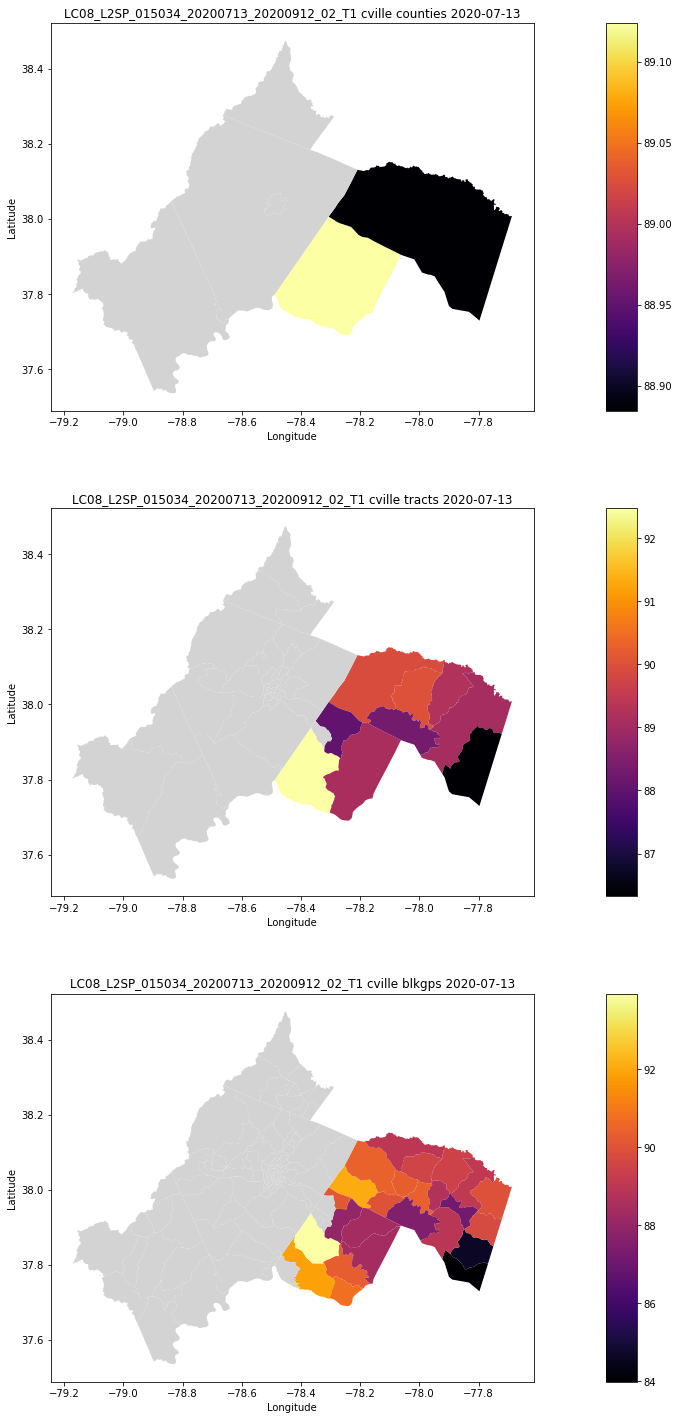

In [265]:
for file in cville_files:
    plot_file(file, cville)

### Charlottesville City Temperature Data

In [248]:
# plot all data, just for the City of Charlottesville
just_cville = {x: cville[x][cville[x].COUNTYFP == "540"] for x in cville}

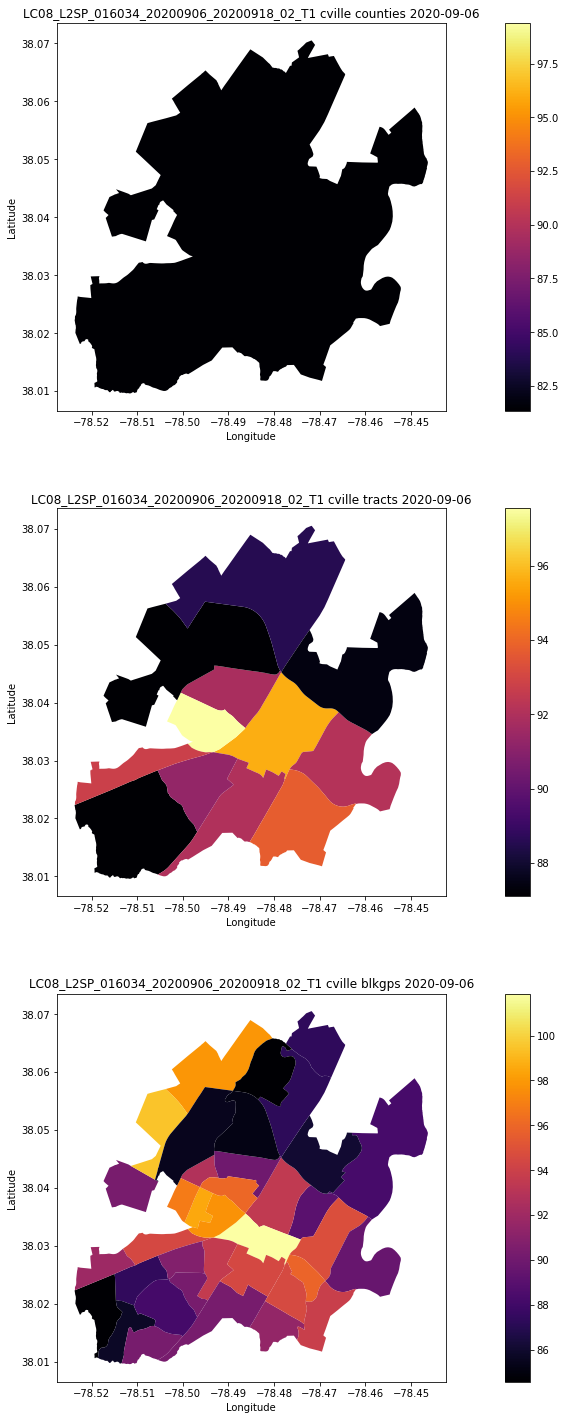

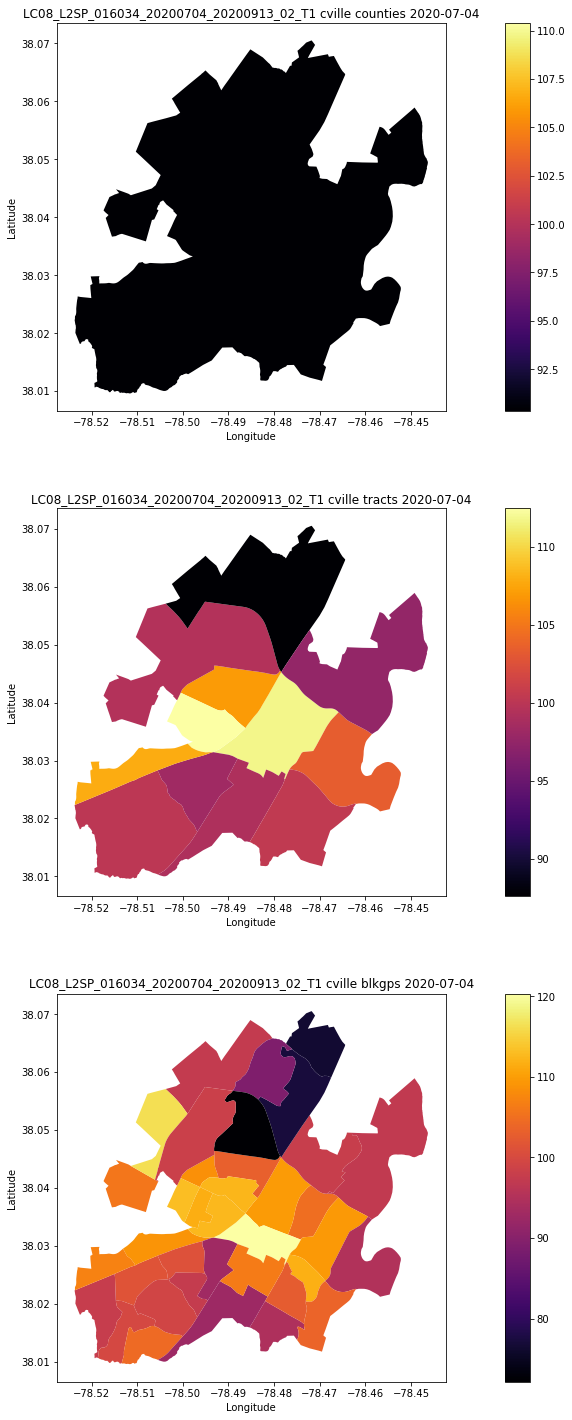

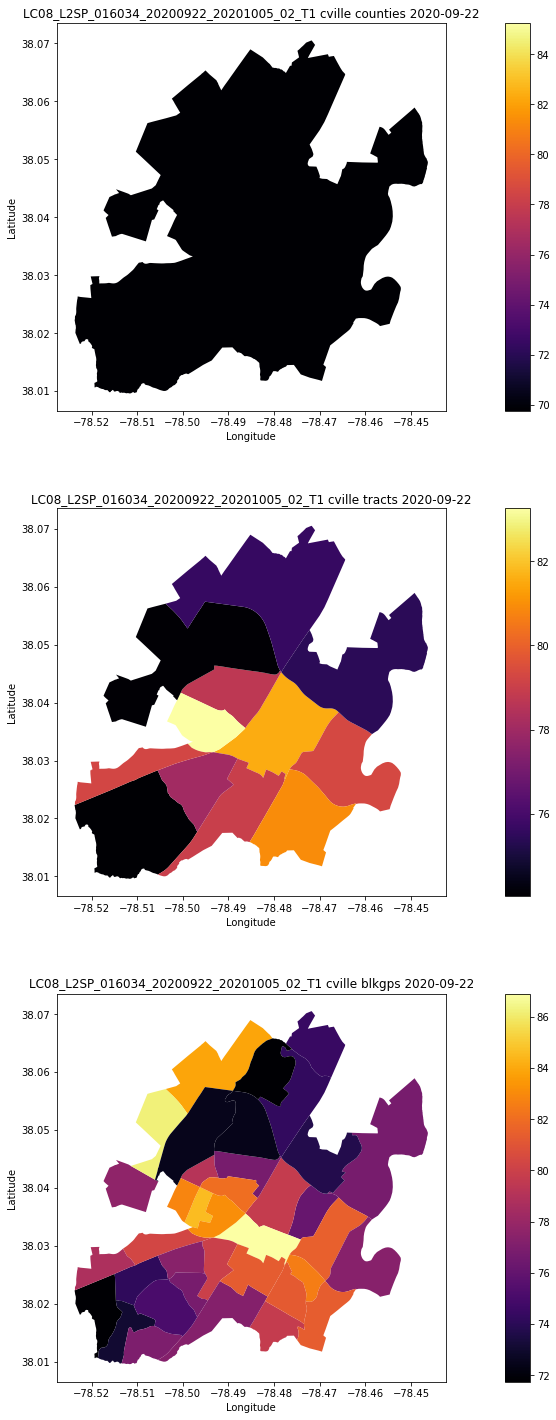

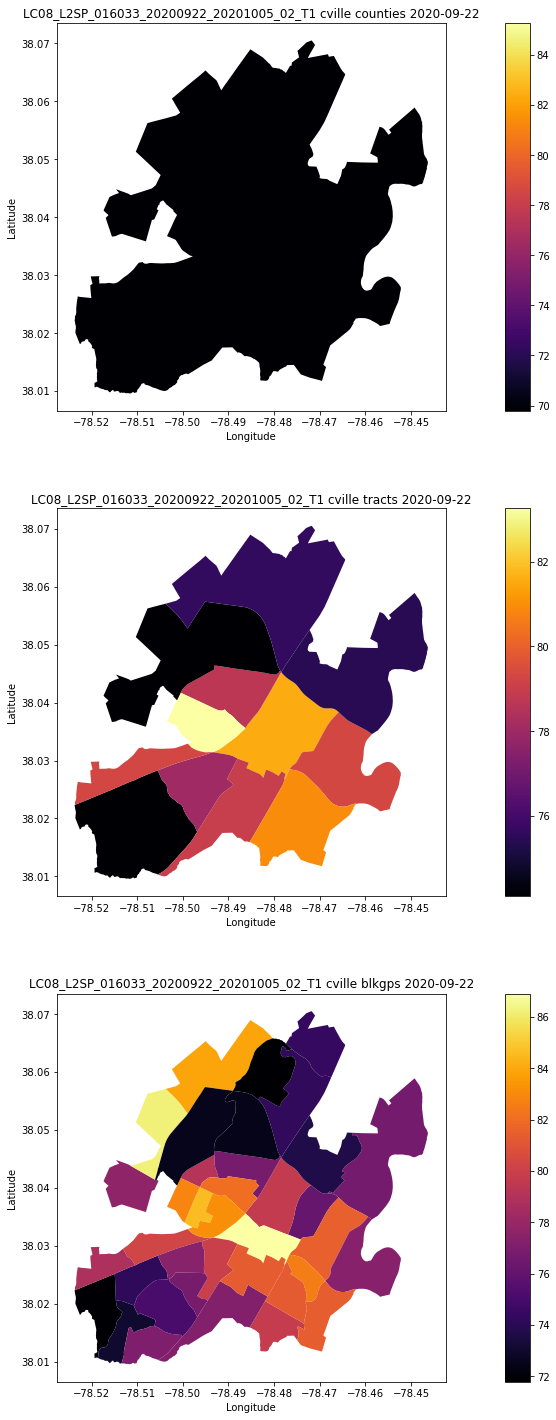

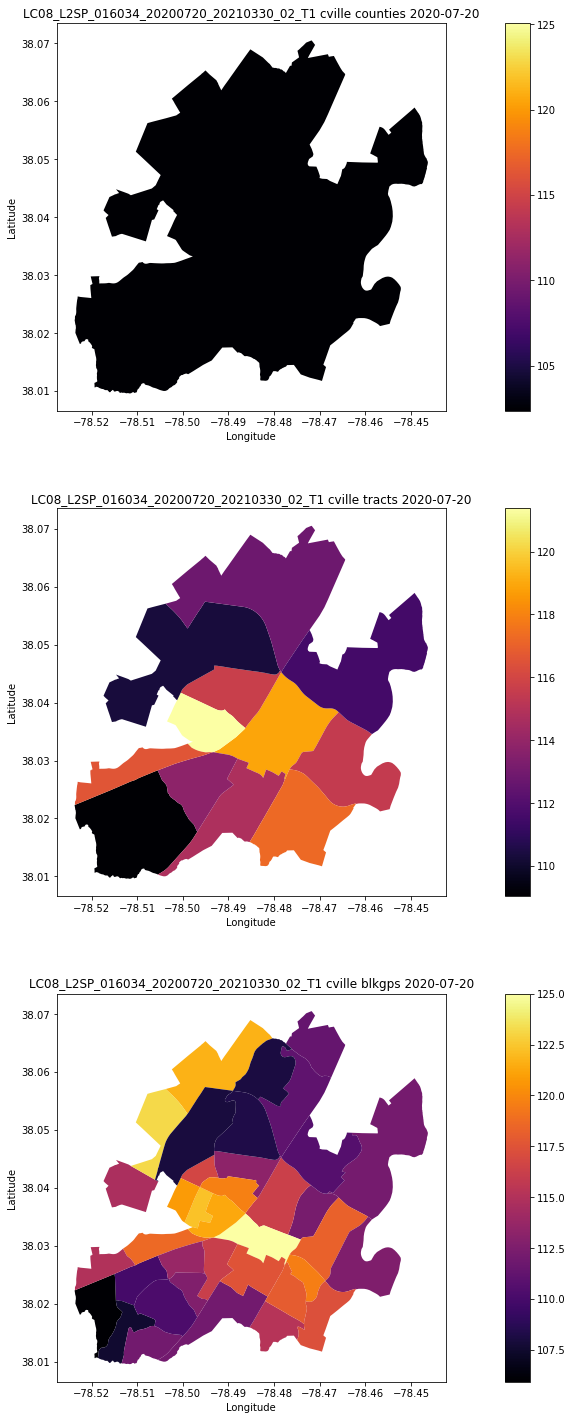

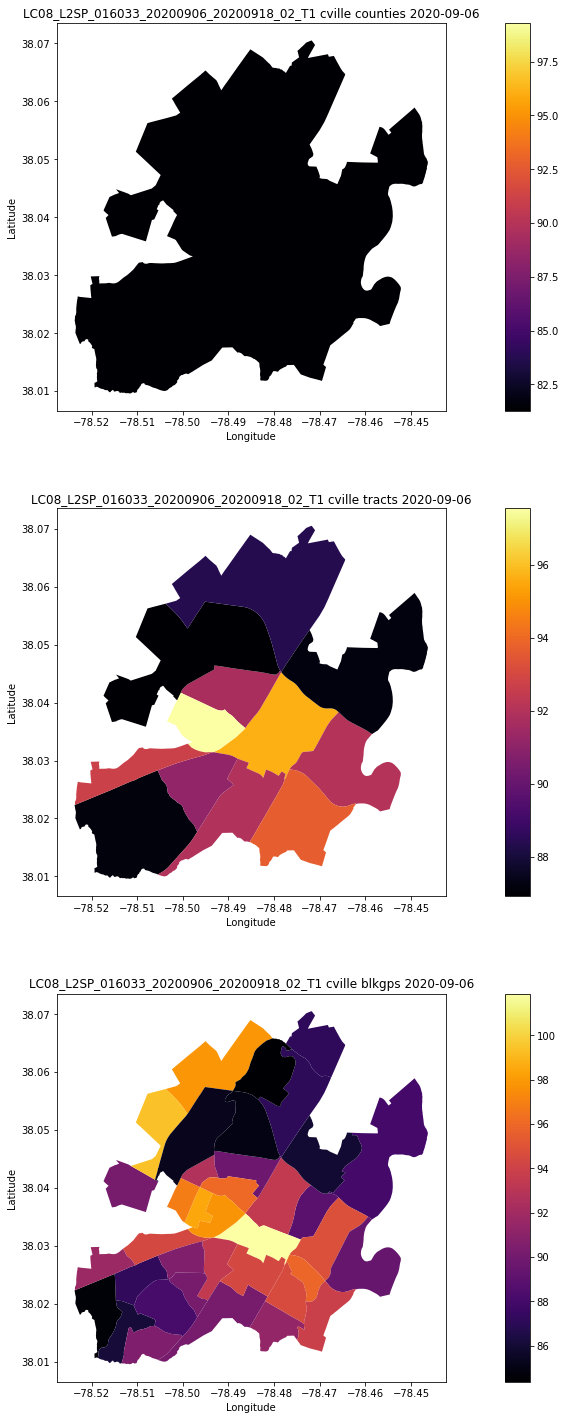

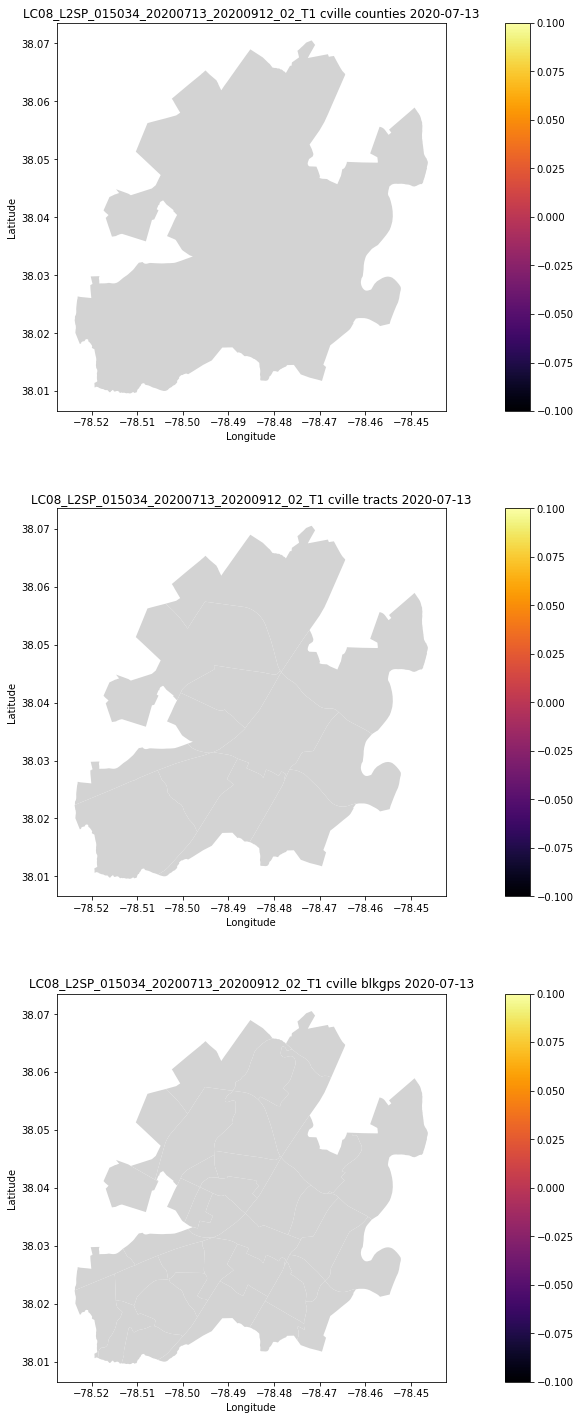

In [250]:
for file in cville_files:
    plot_file(file, just_cville)

### Eastern Shore Region Temperature Data

In [251]:
easternShore_files = easternShore['counties'].file.value_counts().index.tolist()
easternShore_files

['LC08_L2SP_014034_20200722_20200911_02_T1']

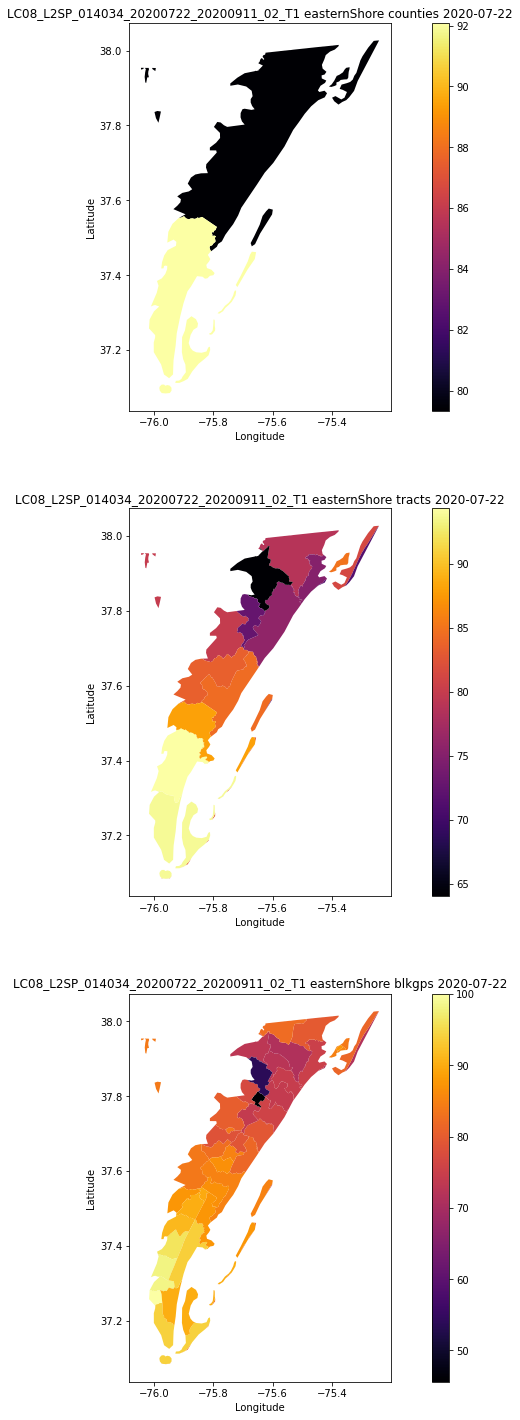

In [252]:
for file in easternShore_files:
    plot_file(file, easternShore)

## Missing Data

Since we're looking at several scenes, which represent photos of the Earth at a specific date and time, some regions aren't fully covered by one scene. This particularly happens with the Charlottesville region, where there are no scenes that fully cover the reion. Due to this issue, I thought it was important to explore the missingness of the data for each file. 

In the plots above, some regions might have partial missing data, which is hard to show visually. I grayed out regions that had no data, but wasn't able to show what regions were missing significant data. Below, I explore missingness in the surface temperature data.

### Charlottesville Region Missingness
The first plot below demonstrates how a single scene doesn't fully cover the Charlottesville region. The red boxes represent the spatial coverage of 2 different scenes and the blue polygons reprepsent the county lines for the Charlottesville region.

In [1]:
from shapely.geometry import Polygon
import json

one = cville['counties'][cville['counties'].file == cville_files[0]]
one = one.to_crs("EPSG:4326")
one = one.iloc[[0]].drop(columns=['geometry'])
one['geometry'] = Polygon([(x[0], x[1]) for x in json.loads(one.spatial_coverage[0])])

two = cville['counties'][cville['counties'].file == cville_files[6]]
two = two.to_crs("EPSG:4326")
two = two.iloc[[0]].drop(columns=['geometry'])
two['geometry'] = Polygon([(x[0], x[1]) for x in json.loads(two.spatial_coverage[0])])

NameError: name 'cville' is not defined

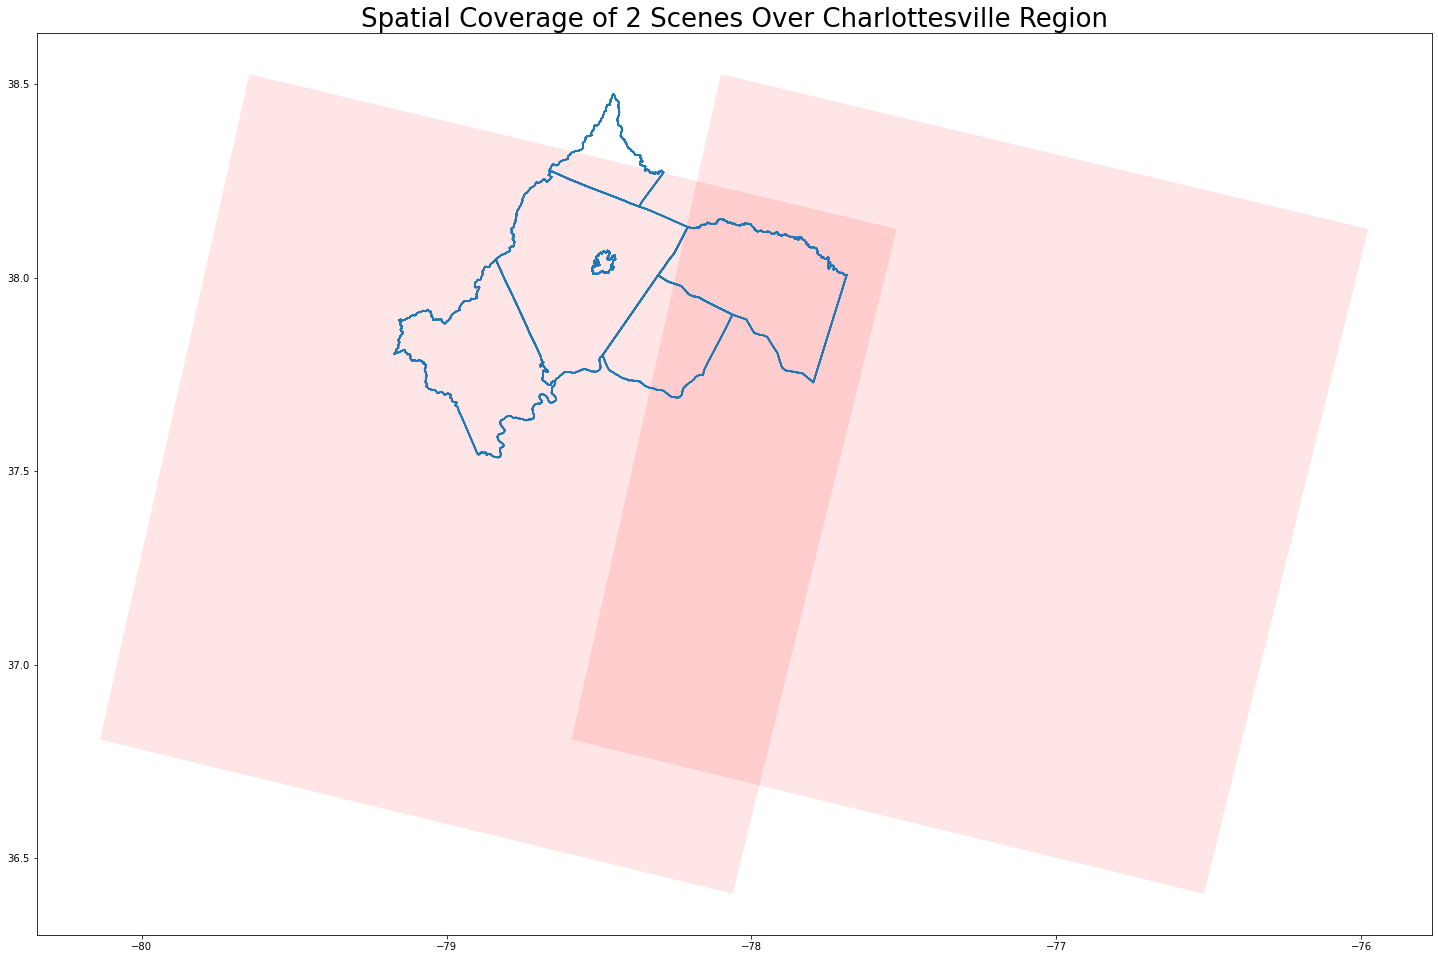

In [310]:
f, ax = plt.subplots(figsize=(25, 25))
ax.set_title('Spatial Coverage of 2 Scenes Over Charlottesville Region', fontsize=26)
one.plot(ax=ax, color = 'red', alpha = 0.10)
two.plot(ax=ax, color = 'red', alpha = 0.10)
cville['counties'].boundary.plot(ax=ax)
plt.show()

The figures below visualize the proportion of missing data in a geometry for that scene. As you can see, some scenes miss certain regions entirely.

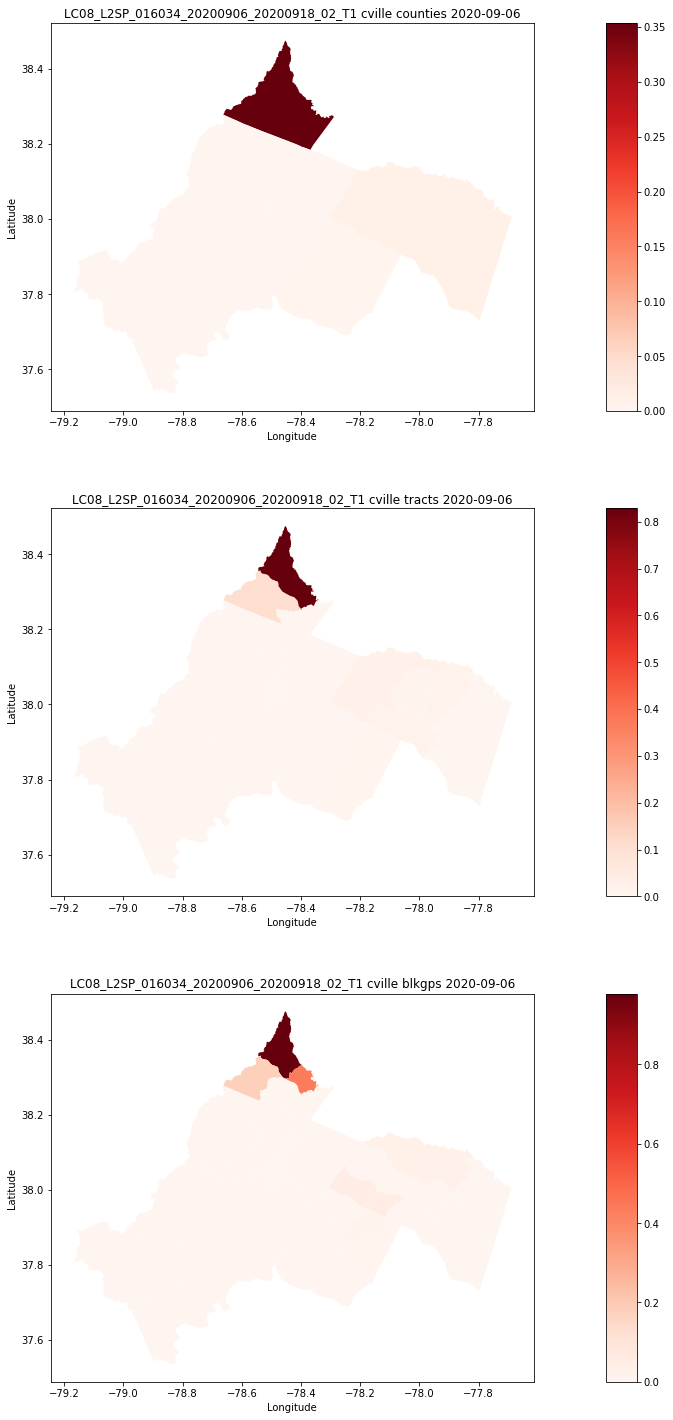

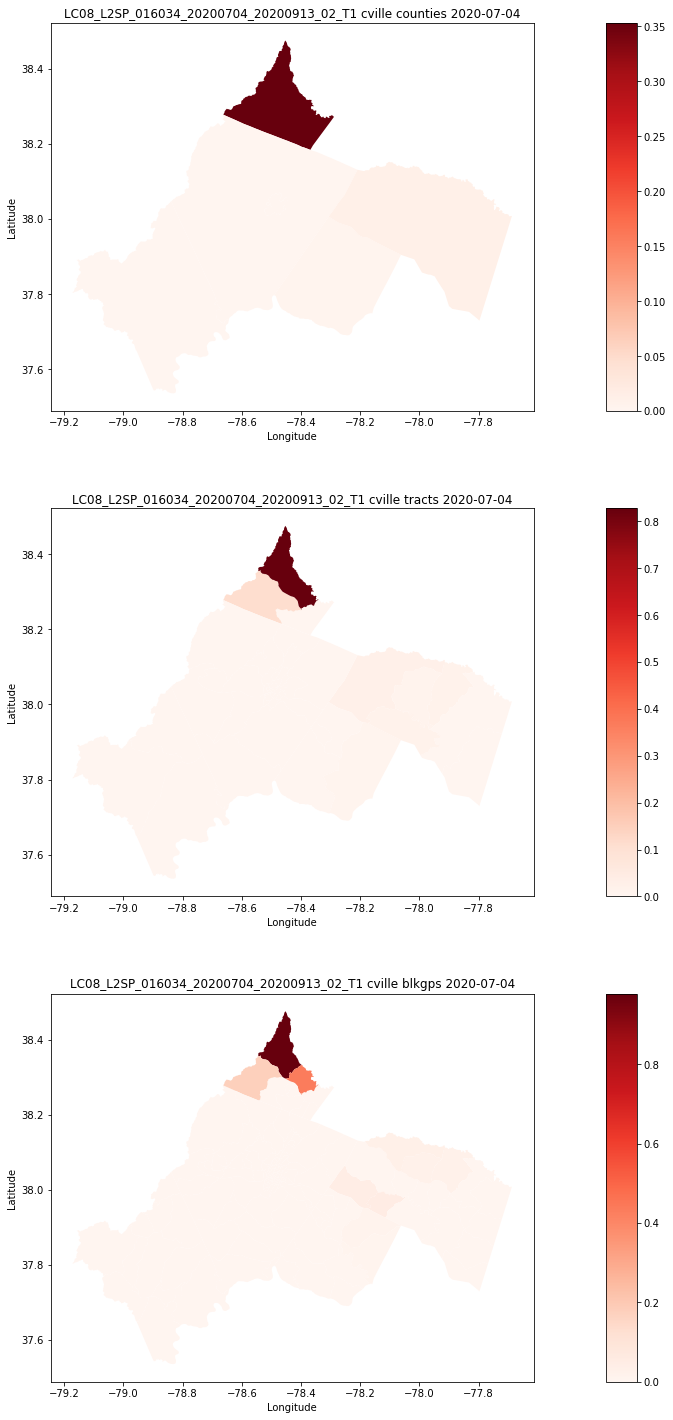

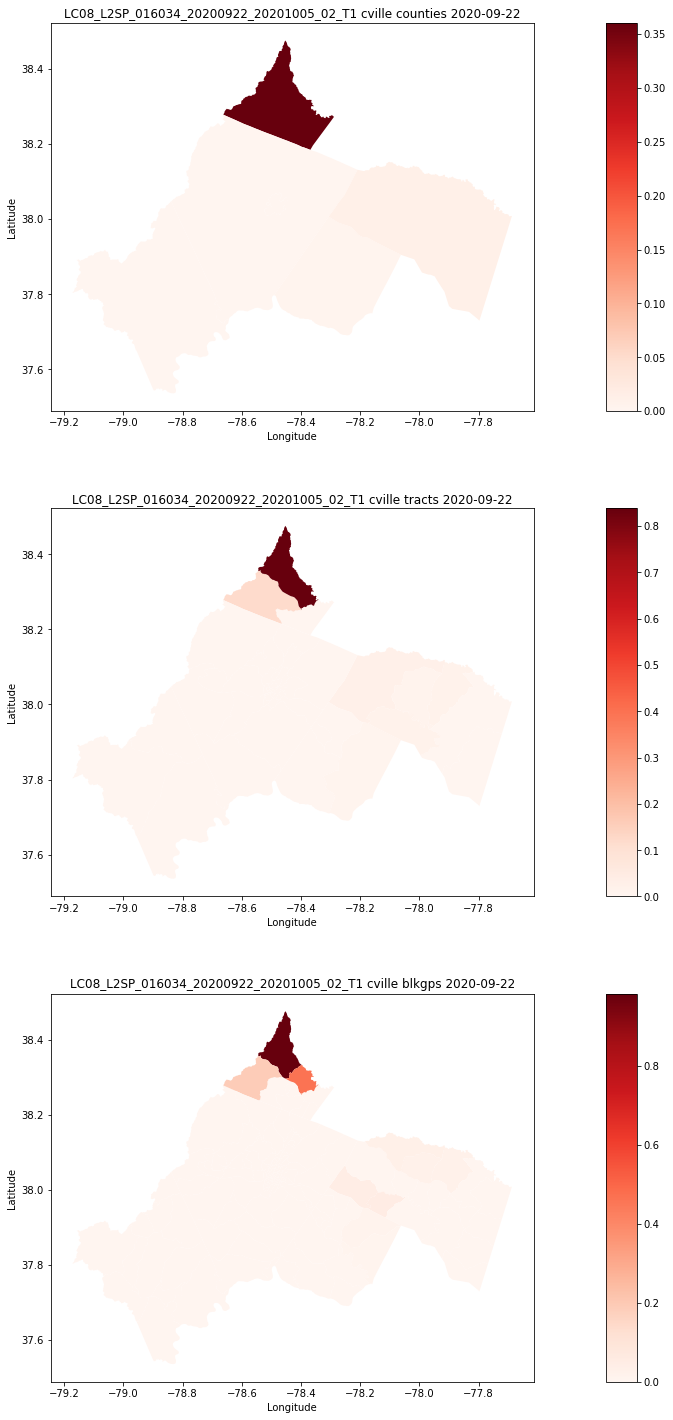

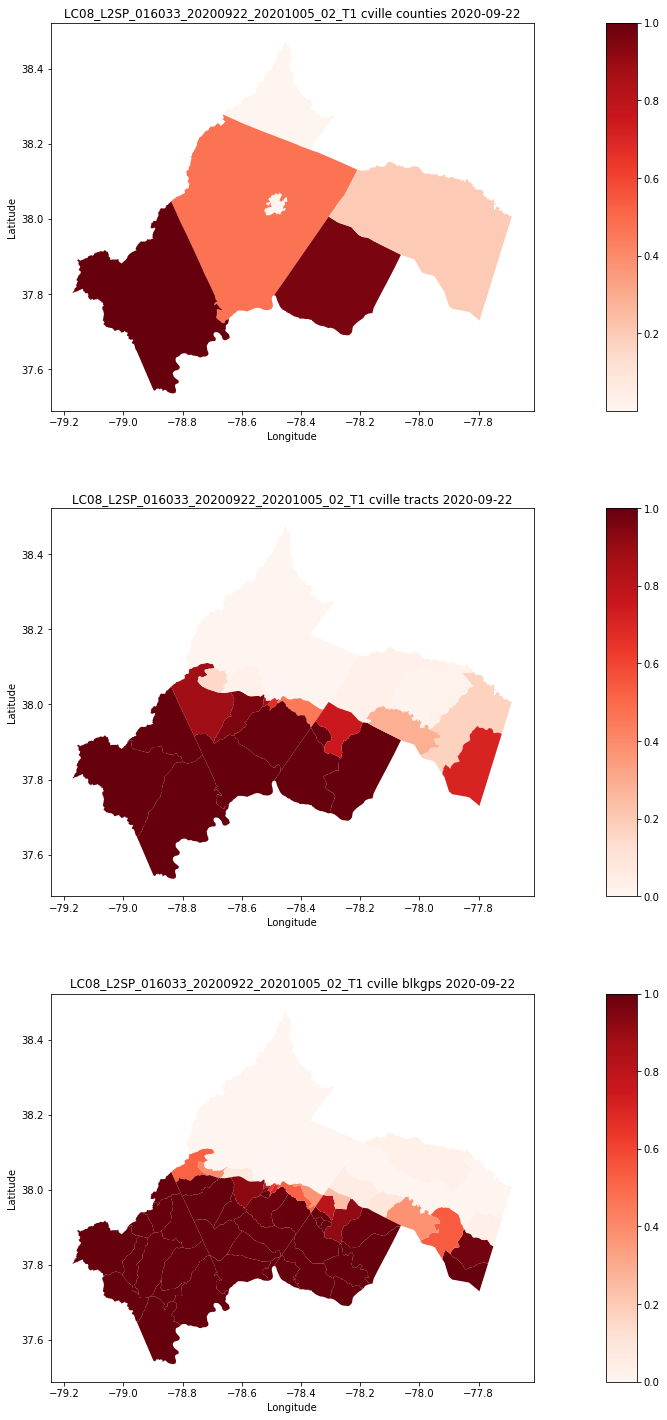

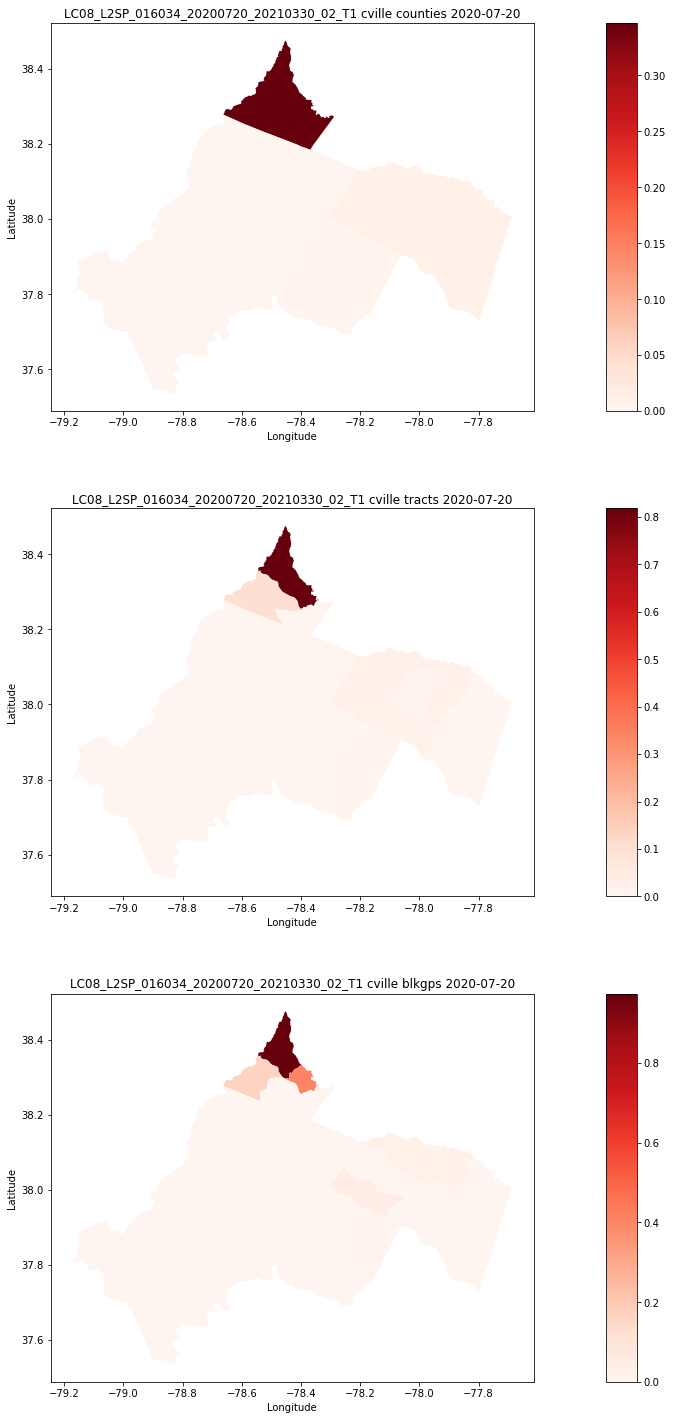

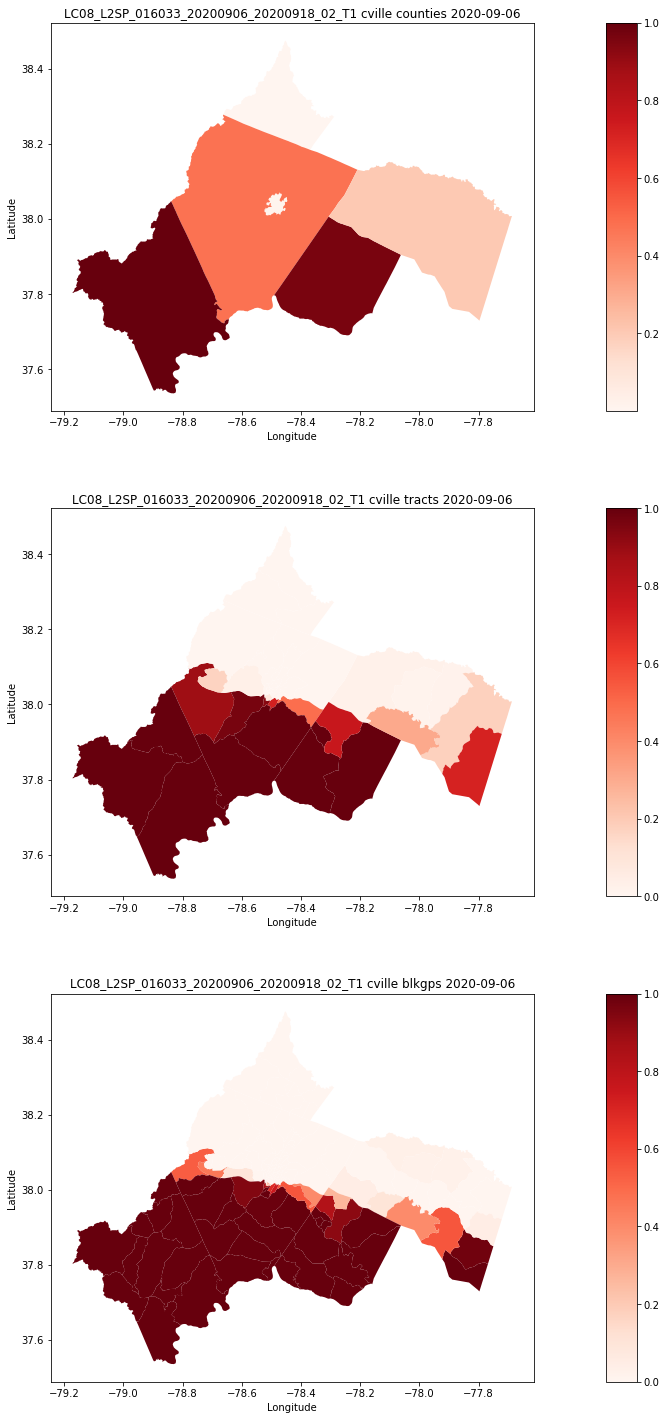

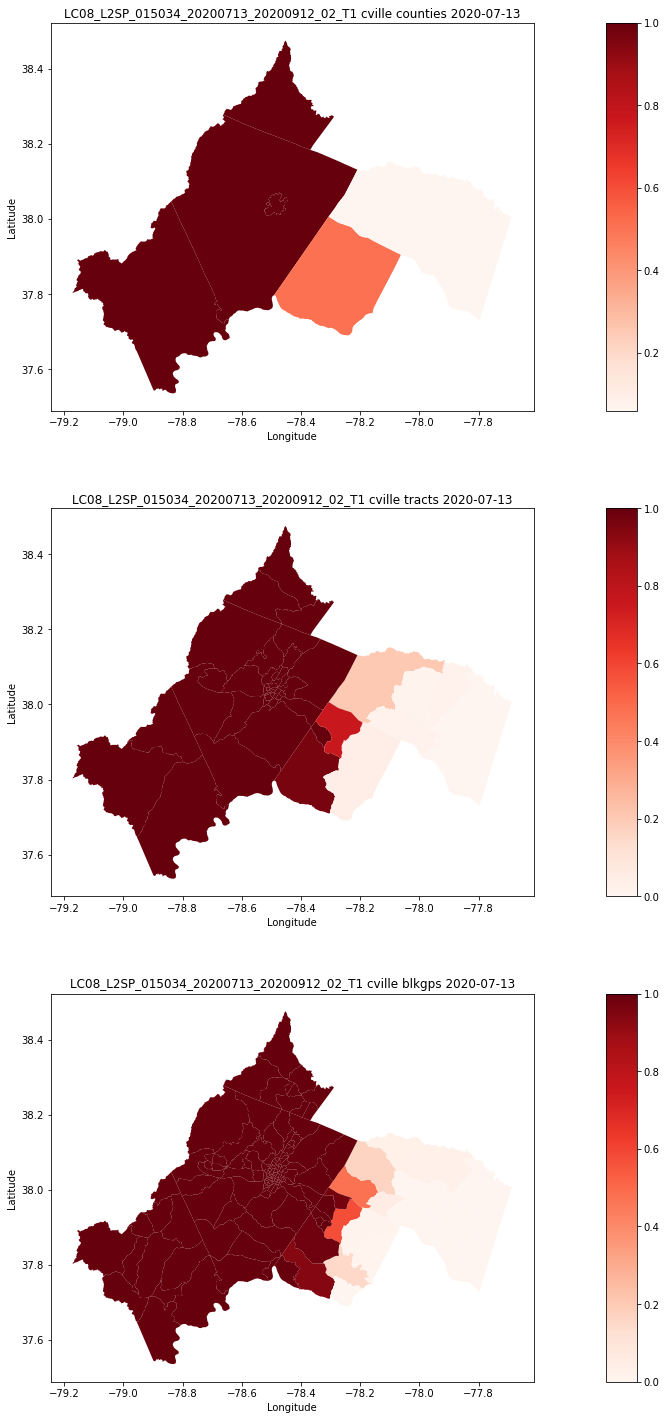

In [253]:
for file in cville_files:
    plot_file(file, cville, col="prop_nodata", cmap="Reds")

### Eastern Shore Missing Data
With the Eastern Shore, there are some scenes that cover the whole region, so missingness is not as much of a problem. It is confusing to see, however, that there is still some missing data. This might be from the actual data itself.

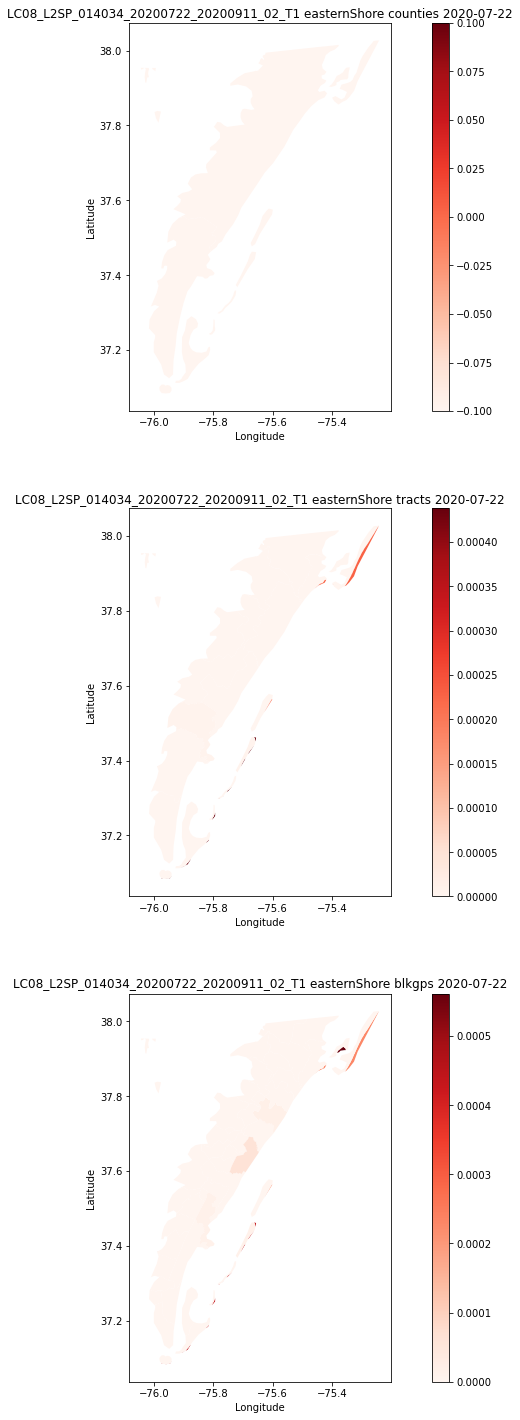

In [254]:
for file in easternShore_files:
    plot_file(file, easternShore, col="prop_nodata", cmap="Reds")